In [321]:
import common
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [322]:
import casadi as ca

def casadi_sos_gen(sos):
    u = ca.SX.sym('u')
    x1 = ca.SX.sym('x1', len(sos)*2)
    x2 = ca.SX.zeros(len(sos)*2)
    u1i = u
    for i, sos_i in enumerate(sos):
        x1i = x1[2*i: 2*(i+1)]
        [A, B, C, D] = scipy.signal.tf2ss(sos_i[:3], sos_i[3:])
        x2i = A @ x1i + B @ u1i
        y1i = C @ x1i + D @ u1i
        x2[2*i: 2*(i+1)] = x2i
        u1i = y1i
    y = y1i
    return ca.Function('sos', [u, x1], [y, x2], ['u', 'x1'], ['y', 'x2'])

fs = 500
N, Wn = scipy.signal.buttord(wp=[0.0, 200.0], ws=[30.0, 90.0], gpass=1, gstop=40, fs=fs)
print('N', N, 'Wn', Wn)
sos = scipy.signal.butter(N, Wn, btype='bandstop', output='sos', fs=fs)
f_butter = casadi_sos_gen(sos)

N 3 Wn [  7.77932336 188.8779009 ]


In [323]:
def simulate_filter(f, t, u, n):
    x1 = np.zeros(n)
    data = {
        't': [],
        'u': [],
        'x': [],
        'y': []
    }
    for ti, ui in zip(t, u):
        y, x2 = f(ui, x1)
        x2 = np.array(x2).reshape(-1)
        y = np.array(y).reshape(-1)
        data['t'].append(ti)
        data['x'].append(x2)
        data['y'].append(y)
        data['u'].append(ui)
        x1 = np.array(x2)
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

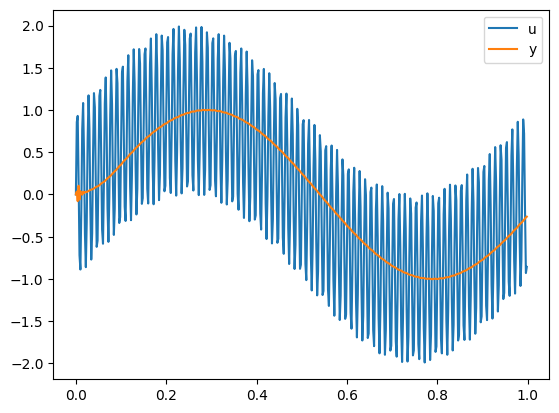

In [324]:
T = 0.002 # time step
wn = 2*np.pi*80 # 80 hz cut frequency
t = np.arange(0, 1, T)
u = np.sin(2*np.pi*t) + np.sin(2*np.pi*80*t)

data = simulate_filter(f_butter, t, u, 2*len(sos))
#plt.plot(data['t'], data['x'], label='x')
plt.plot(data['t'], data['u'], label='u')
plt.plot(data['t'], data['y'], label='y')
plt.legend()
plt.show()

Text(0, 0.5, 'y')

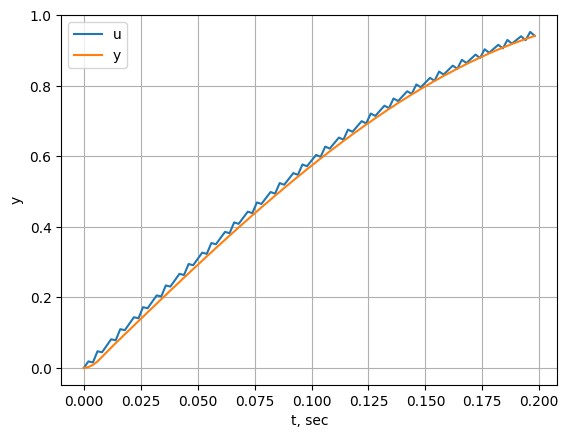

In [331]:
def simulate_filter2(wn, t, u):
    x1 = np.array([0, 0])
    data = {
        't': [],
        'u': [],
        'x': [],
        'y': []
    }
    for ti, ui in zip(t, u):
        x2, y = f['butterworth_2_filter'](T, wn, x1, ui)
        x2 = np.array(x2).reshape(-1)
        y = np.array(y).reshape(-1)
        data['t'].append(ti)
        data['x'].append(x2)
        data['y'].append(y)
        data['u'].append(ui)
        x1 = np.array(x2)
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

f = common.derive_butterworth_2_filter()

T = 0.002 # time step
wn = 2*np.pi*80 # 80 hz cut frequency
t = np.arange(0, 0.2, T)
u = np.sin(2*np.pi*t) + 0.01*np.sin(2*np.pi*200*t)

data = simulate_filter2(wn, t, u)
#plt.plot(data['t'], data['x'], label='x')

plt.figure()
plt.plot(data['t'], data['u'], label='u')
plt.plot(data['t'], data['y'], label='y')
plt.legend()
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('y')

In [326]:
[A, B, C, D] = f['butterworth_2_filter_ss'](T, wn)
sys = scipy.signal.dlti(A, B, C, D, dt=T)
sys

StateSpaceDiscrete(
array([[ 0.        ,  1.        ],
       [-0.27593288,  0.76122161]]),
array([[0.],
       [1.]]),
array([[0.09317138, 0.35530797]]),
array([[0.12867782]]),
dt: 0.002
)

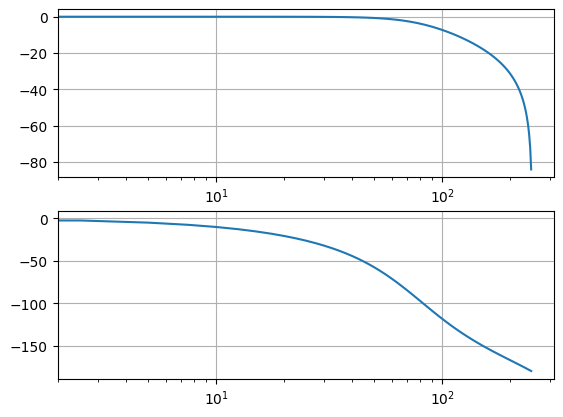

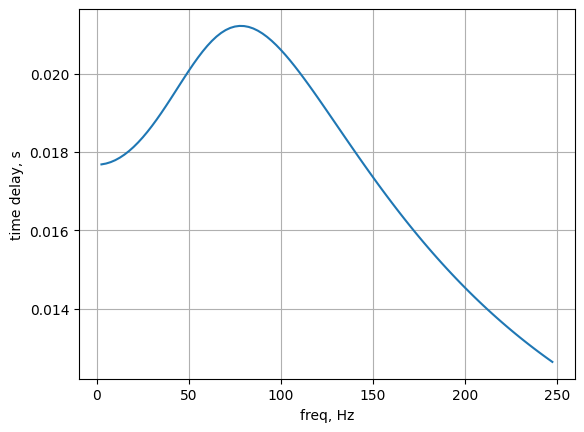

In [327]:
w, mag, phase = signal.dbode(sys)
f = w/(2*np.pi)

plt.figure()

plt.subplot(211)
plt.semilogx(f, mag)
plt.grid()
    
plt.subplot(212)
plt.semilogx(f, phase)
plt.grid()

plt.figure()

plt.plot(f[1:], -np.deg2rad(phase[1:])/f[1:])
plt.xlabel('freq, Hz')
plt.ylabel('time delay, s')
plt.grid()